In [1]:
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Custom Dataset

In [3]:
class BanglaDataset(Dataset):
    def __init__(self, df, max_seq_len=90):
        self.df = df
        self.nsamples = len(self.df)
        glove_data_file = r'E:\Bangla-Sentiment-Analysis\Word Embeddings\fine_tuned_glove_vectors_1.txt'  
        self.glove_vec = self.load_glove_model(glove_data_file)
        self.max_seq_len = max_seq_len

    def load_glove_model(self, file):
        print("Loading GloVe Model")
        glove_model = {}
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                glove_model[word] = embedding
        print(f"{len(glove_model)} words loaded!")
        return glove_model

    def __getitem__(self, index):
        review = self.df.iloc[index]['clean_sentence']
        sentiment = self.df.iloc[index]['Sentiment']

        word_list = nltk.word_tokenize(review)
        x = []
        for w in word_list:
            w = w.lower()
            if w in self.glove_vec:
                x.append(self.glove_vec[w])

        # Convert to 2D array if not empty
        if len(x) > 0:
            x = np.array(x)
        else:
            x = np.zeros((0, 300))  # Ensure x is 2D even if empty

        # Truncate if greater than max len
        x = x[:self.max_seq_len]
        # Padding if less than max len
        padding_len = self.max_seq_len - x.shape[0]
        padding = np.zeros((padding_len, 300))  
        x = np.concatenate((x, padding), axis=0)

        # Convert sentiment into a class label
        y = sentiment

        x = torch.FloatTensor(x)
        y = torch.LongTensor([y])  

        return x, y

    def __len__(self):
        return self.nsamples

# Model

In [4]:
class LSTM_Model(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes=3, bidirectional=True, dropout_rate=0.2):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional, dropout=dropout_rate)
        self.bidirectional = bidirectional
        if bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        if self.bidirectional:
            hn = torch.cat((hn[0], hn[1]), dim=1)
        else:
            hn = hn.squeeze(0)
        pred = self.fc(hn)
        return pred

# Load Dataset

In [5]:
train_val_df = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\train_val_data_df.xlsx')
test_df = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\test_data_df.xlsx')

# Convert Sentiments to numeric labels
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_val_df['Sentiment'] = train_val_df['Sentiment'].map(sentiment_mapping)

sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)

In [6]:
# K-Fold Cross Validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)
fold = 0

# To store metrics and losses for each fold
all_fold_metrics = []
all_fold_train_losses = []
all_fold_val_losses = []
best_fold_index = -1
best_val_loss_overall = float('inf')

# Train Model

In [7]:
for train_index, val_index in kf.split(train_val_df):
    fold += 1
    model = LSTM_Model(embedding_dim=300, hidden_dim=64, num_classes=3, bidirectional=True, dropout_rate=0.2)
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\nStarting Fold {fold}")
    train_data = train_val_df.iloc[train_index]
    val_data = train_val_df.iloc[val_index]

    # Initialize datasets
    train_dataset = BanglaDataset(train_data)
    validation_dataset = BanglaDataset(val_data)

    # Create dataloaders
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=True, num_workers=0)

    # Train the model
    nepoch = 10
    fold_train_loss = []
    fold_val_loss = []

    best_val_loss = float('inf')
    best_metrics = {'accuracy': 0, 'f_score': 0, 'precision': 0, 'recall': 0, 'best_epoch': 0}

    for i in range(nepoch):
        print(f"\nEpoch {i + 1}:")

        # --- Training ---
        model.train()
        tr_loss, n_tr_steps = 0., 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)
            (x, y) = batch

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y.view(-1))
            tr_loss += loss.item()
            n_tr_steps += 1

            loss.backward()
            optimizer.step()

        mean_train_loss = tr_loss / n_tr_steps
        fold_train_loss.append(mean_train_loss)

        # --- Validation ---
        model.eval()
        val_loss, n_val_steps = 0., 0
        predictions, labels = [], []
        with torch.no_grad():
            for step, batch in enumerate(validation_dataloader):
                batch = tuple(t.to(DEVICE) for t in batch)
                (x, y) = batch
                out = model(x)
                loss = loss_fn(out, y.view(-1))
                val_loss += loss.item()
                n_val_steps += 1

                # Collect predictions
                preds = torch.argmax(out, dim=1)
                predictions += preds.cpu().numpy().tolist()
                labels += y.cpu().numpy().tolist()

        mean_val_loss = val_loss / n_val_steps
        fold_val_loss.append(mean_val_loss)

        # --- Calculate Metrics ---
        accuracy = accuracy_score(labels, predictions)
        f_score = f1_score(labels, predictions, average="weighted")
        precision = precision_score(labels, predictions, average="weighted")
        recall = recall_score(labels, predictions, average="weighted")

        # Print metrics for the current epoch
        print(f'Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, F Score: {f_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Store best metrics for this fold
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_metrics = {
                'best_epoch': i + 1,  # Store 1-based index for epoch
                'accuracy': accuracy,
                'f_score': f_score,
                'precision': precision,
                'recall': recall,
                'train_loss': mean_train_loss,  # Store best train loss
                'val_loss': mean_val_loss       # Store best validation loss
            }
            # Save the model weights of the best epoch in this fold
            torch.save(model.state_dict(), f"best_finetuned_glove_bilstm_model_fold_{fold}.pt")

    # Store losses for this fold
    all_fold_train_losses.append(fold_train_loss)
    all_fold_val_losses.append(fold_val_loss)

    # Store metrics for this fold
    all_fold_metrics.append(best_metrics)

    # Track the best fold based on validation loss
    if best_val_loss < best_val_loss_overall:
        best_val_loss_overall = best_val_loss
        best_fold_index = fold - 1  # Store the fold index (0-based)

    # After the fold training is complete
    print(f"\nBest Metrics for Fold {fold}:")
    print(f"Best Epoch: {best_metrics['best_epoch']}")
    print(f"Train Loss: {best_metrics['train_loss']:.4f}, Validation Loss: {best_metrics['val_loss']:.4f}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}, F Score: {best_metrics['f_score']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}, Recall: {best_metrics['recall']:.4f}")

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Starting Fold 1
Loading GloVe Model
23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6889, Validation Loss: 0.6476
Accuracy: 0.7417, F Score: 0.7441, Precision: 0.7526, Recall: 0.7417

Epoch 2:
Train Loss: 0.5927, Validation Loss: 0.6224
Accuracy: 0.7520, F Score: 0.7444, Precision: 0.7453, Recall: 0.7520

Epoch 3:
Train Loss: 0.5358, Validation Loss: 0.6314
Accuracy: 0.7466, F Score: 0.7423, Precision: 0.7398, Recall: 0.7466

Epoch 4:
Train Loss: 0.4840, Validation Loss: 0.6406
Accuracy: 0.7549, F Score: 0.7528, Precision: 0.7516, Recall: 0.7549

Epoch 5:
Train Loss: 0.4298, Validation Loss: 0.6943
Accuracy: 0.7411, F Score: 0.7410, Precision: 0.7440, Recall: 0.7411

Epoch 6:
Train Loss: 0.3830, Validation Loss: 0.7235
Accuracy: 0.7325, F Score: 0.7334, Precision: 0.7350, Recall: 0.7325

Epoch 7:
Train Loss: 0.3375, Validation Loss: 0.7990
Accuracy: 0.7313, F Score: 0.7284, Precision: 0.7275, Recall: 0.7313

Epoch 8:
Train Loss: 0.3010, Validation L

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6933, Validation Loss: 0.6237
Accuracy: 0.7575, F Score: 0.7510, Precision: 0.7481, Recall: 0.7575

Epoch 2:
Train Loss: 0.5956, Validation Loss: 0.6135
Accuracy: 0.7537, F Score: 0.7540, Precision: 0.7550, Recall: 0.7537

Epoch 3:
Train Loss: 0.5362, Validation Loss: 0.6321
Accuracy: 0.7517, F Score: 0.7420, Precision: 0.7394, Recall: 0.7517

Epoch 4:
Train Loss: 0.4843, Validation Loss: 0.6341
Accuracy: 0.7569, F Score: 0.7530, Precision: 0.7513, Recall: 0.7569

Epoch 5:
Train Loss: 0.4326, Validation Loss: 0.6793
Accuracy: 0.7520, F Score: 0.7465, Precision: 0.7432, Recall: 0.7520

Epoch 6:
Train Loss: 0.3831, Validation Loss: 0.7116
Accuracy: 0.7420, F Score: 0.7360, Precision: 0.7328, Recall: 0.7420

Epoch 7:
Train Loss: 0.3391, Validation Loss: 0.7824
Accuracy: 0.7411, F Score: 0.7388, Precision: 0.7375, Recall: 0.7411

Epoch 8:
Train Loss: 0.3041, Validation Loss: 0.8293
Accuracy: 0.7445, F Score

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6850, Validation Loss: 0.6593
Accuracy: 0.7422, F Score: 0.7315, Precision: 0.7350, Recall: 0.7422

Epoch 2:
Train Loss: 0.5888, Validation Loss: 0.6385
Accuracy: 0.7489, F Score: 0.7513, Precision: 0.7556, Recall: 0.7489

Epoch 3:
Train Loss: 0.5321, Validation Loss: 0.6346
Accuracy: 0.7489, F Score: 0.7434, Precision: 0.7434, Recall: 0.7489

Epoch 4:
Train Loss: 0.4747, Validation Loss: 0.6602
Accuracy: 0.7540, F Score: 0.7482, Precision: 0.7460, Recall: 0.7540

Epoch 5:
Train Loss: 0.4235, Validation Loss: 0.6990
Accuracy: 0.7402, F Score: 0.7359, Precision: 0.7347, Recall: 0.7402

Epoch 6:
Train Loss: 0.3741, Validation Loss: 0.7444
Accuracy: 0.7353, F Score: 0.7289, Precision: 0.7263, Recall: 0.7353

Epoch 7:
Train Loss: 0.3311, Validation Loss: 0.7896
Accuracy: 0.7399, F Score: 0.7312, Precision: 0.7277, Recall: 0.7399

Epoch 8:
Train Loss: 0.2929, Validation Loss: 0.9089
Accuracy: 0.7158, F Score

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6937, Validation Loss: 0.6377
Accuracy: 0.7394, F Score: 0.7346, Precision: 0.7314, Recall: 0.7394

Epoch 2:
Train Loss: 0.5959, Validation Loss: 0.6284
Accuracy: 0.7451, F Score: 0.7333, Precision: 0.7326, Recall: 0.7451

Epoch 3:
Train Loss: 0.5364, Validation Loss: 0.6307
Accuracy: 0.7471, F Score: 0.7325, Precision: 0.7313, Recall: 0.7471

Epoch 4:
Train Loss: 0.4824, Validation Loss: 0.6591
Accuracy: 0.7486, F Score: 0.7392, Precision: 0.7366, Recall: 0.7486

Epoch 5:
Train Loss: 0.4310, Validation Loss: 0.6983
Accuracy: 0.7468, F Score: 0.7376, Precision: 0.7349, Recall: 0.7468

Epoch 6:
Train Loss: 0.3793, Validation Loss: 0.7353
Accuracy: 0.7362, F Score: 0.7260, Precision: 0.7234, Recall: 0.7362

Epoch 7:
Train Loss: 0.3368, Validation Loss: 0.7790
Accuracy: 0.7397, F Score: 0.7309, Precision: 0.7282, Recall: 0.7397

Epoch 8:
Train Loss: 0.3007, Validation Loss: 0.8615
Accuracy: 0.7322, F Score

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6913, Validation Loss: 0.6499
Accuracy: 0.7420, F Score: 0.7349, Precision: 0.7356, Recall: 0.7420

Epoch 2:
Train Loss: 0.5931, Validation Loss: 0.6391
Accuracy: 0.7480, F Score: 0.7454, Precision: 0.7482, Recall: 0.7480

Epoch 3:
Train Loss: 0.5349, Validation Loss: 0.6429
Accuracy: 0.7489, F Score: 0.7428, Precision: 0.7399, Recall: 0.7489

Epoch 4:
Train Loss: 0.4786, Validation Loss: 0.6679
Accuracy: 0.7394, F Score: 0.7400, Precision: 0.7414, Recall: 0.7394

Epoch 5:
Train Loss: 0.4258, Validation Loss: 0.7112
Accuracy: 0.7359, F Score: 0.7302, Precision: 0.7265, Recall: 0.7359

Epoch 6:
Train Loss: 0.3756, Validation Loss: 0.7754
Accuracy: 0.7230, F Score: 0.7253, Precision: 0.7281, Recall: 0.7230

Epoch 7:
Train Loss: 0.3337, Validation Loss: 0.7995
Accuracy: 0.7210, F Score: 0.7186, Precision: 0.7169, Recall: 0.7210

Epoch 8:
Train Loss: 0.2938, Validation Loss: 0.9013
Accuracy: 0.7152, F Score

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6893, Validation Loss: 0.6327
Accuracy: 0.7526, F Score: 0.7384, Precision: 0.7380, Recall: 0.7526

Epoch 2:
Train Loss: 0.5927, Validation Loss: 0.6117
Accuracy: 0.7624, F Score: 0.7554, Precision: 0.7534, Recall: 0.7624

Epoch 3:
Train Loss: 0.5338, Validation Loss: 0.6256
Accuracy: 0.7624, F Score: 0.7587, Precision: 0.7589, Recall: 0.7624

Epoch 4:
Train Loss: 0.4810, Validation Loss: 0.6527
Accuracy: 0.7514, F Score: 0.7536, Precision: 0.7563, Recall: 0.7514

Epoch 5:
Train Loss: 0.4302, Validation Loss: 0.6802
Accuracy: 0.7494, F Score: 0.7492, Precision: 0.7501, Recall: 0.7494

Epoch 6:
Train Loss: 0.3785, Validation Loss: 0.7264
Accuracy: 0.7374, F Score: 0.7297, Precision: 0.7267, Recall: 0.7374

Epoch 7:
Train Loss: 0.3375, Validation Loss: 0.7631
Accuracy: 0.7365, F Score: 0.7355, Precision: 0.7349, Recall: 0.7365

Epoch 8:
Train Loss: 0.2970, Validation Loss: 0.8683
Accuracy: 0.7239, F Score

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6918, Validation Loss: 0.6407
Accuracy: 0.7450, F Score: 0.7286, Precision: 0.7305, Recall: 0.7450

Epoch 2:
Train Loss: 0.5908, Validation Loss: 0.6213
Accuracy: 0.7534, F Score: 0.7476, Precision: 0.7473, Recall: 0.7534

Epoch 3:
Train Loss: 0.5344, Validation Loss: 0.6244
Accuracy: 0.7479, F Score: 0.7423, Precision: 0.7398, Recall: 0.7479

Epoch 4:
Train Loss: 0.4755, Validation Loss: 0.6458
Accuracy: 0.7468, F Score: 0.7425, Precision: 0.7403, Recall: 0.7468

Epoch 5:
Train Loss: 0.4240, Validation Loss: 0.6839
Accuracy: 0.7373, F Score: 0.7325, Precision: 0.7308, Recall: 0.7373

Epoch 6:
Train Loss: 0.3712, Validation Loss: 0.7360
Accuracy: 0.7396, F Score: 0.7352, Precision: 0.7333, Recall: 0.7396

Epoch 7:
Train Loss: 0.3289, Validation Loss: 0.8225
Accuracy: 0.7381, F Score: 0.7346, Precision: 0.7341, Recall: 0.7381

Epoch 8:
Train Loss: 0.2923, Validation Loss: 0.8609
Accuracy: 0.7304, F Score

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


23683 words loaded!
Loading GloVe Model
23683 words loaded!

Epoch 1:
Train Loss: 0.6855, Validation Loss: 0.6690
Accuracy: 0.7321, F Score: 0.7309, Precision: 0.7306, Recall: 0.7321

Epoch 2:
Train Loss: 0.5897, Validation Loss: 0.6550
Accuracy: 0.7376, F Score: 0.7351, Precision: 0.7339, Recall: 0.7376

Epoch 3:
Train Loss: 0.5312, Validation Loss: 0.6719
Accuracy: 0.7425, F Score: 0.7365, Precision: 0.7335, Recall: 0.7425

Epoch 4:
Train Loss: 0.4771, Validation Loss: 0.6948
Accuracy: 0.7338, F Score: 0.7238, Precision: 0.7216, Recall: 0.7338

Epoch 5:
Train Loss: 0.4232, Validation Loss: 0.7414
Accuracy: 0.7312, F Score: 0.7267, Precision: 0.7244, Recall: 0.7312

Epoch 6:
Train Loss: 0.3735, Validation Loss: 0.7846
Accuracy: 0.7287, F Score: 0.7218, Precision: 0.7180, Recall: 0.7287

Epoch 7:
Train Loss: 0.3298, Validation Loss: 0.8703
Accuracy: 0.7272, F Score: 0.7221, Precision: 0.7195, Recall: 0.7272

Epoch 8:
Train Loss: 0.2936, Validation Loss: 0.9173
Accuracy: 0.7160, F Score


--------------------------------------------------Best Fold Summary---------------------------------------------------------------------------
Best Fold: 6
Best Epoch: 2
Train Loss: 0.5927
Validation Loss: 0.6117
Accuracy: 0.7624
F Score: 0.7554
Precision: 0.7534
Recall: 0.7624


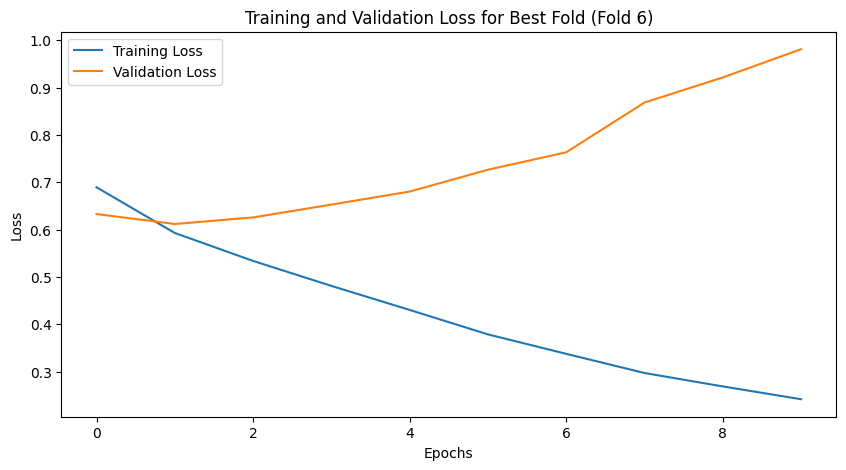

In [8]:
# Print the best fold details
print("\n--------------------------------------------------Best Fold Summary---------------------------------------------------------------------------")

best_fold_metrics = all_fold_metrics[best_fold_index]  # Retrieve the metrics of the best fold

# Print the metrics for the best fold
print(f"Best Fold: {best_fold_index + 1}")
print(f"Best Epoch: {best_fold_metrics['best_epoch']}")
print(f"Train Loss: {best_fold_metrics['train_loss']:.4f}")
print(f"Validation Loss: {best_fold_metrics['val_loss']:.4f}")
print(f"Accuracy: {best_fold_metrics['accuracy']:.4f}")
print(f"F Score: {best_fold_metrics['f_score']:.4f}")
print(f"Precision: {best_fold_metrics['precision']:.4f}")
print(f"Recall: {best_fold_metrics['recall']:.4f}")

# Retrieve the best fold's train and validation loss
best_fold_train_loss = all_fold_train_losses[best_fold_index]
best_fold_val_loss = all_fold_val_losses[best_fold_index]

# Plot the best fold's training and validation loss
plt.figure(figsize=(10, 5))
plt.title(f"Training and Validation Loss for Best Fold (Fold {best_fold_index + 1})")
plt.plot(best_fold_train_loss, label="Training Loss")
plt.plot(best_fold_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Model

In [9]:
print("\n--------------------------------------------------Test Set---------------------------------------------------------------------------")

# After all folds, use the best model (based on validation loss) to evaluate the test dataset
print("\nEvaluating on Test Dataset")

# Prepare the test dataset and dataloader
test_dataset = BanglaDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=0)

# Load the best model's saved weights for the best fold (use the fold with best validation performance)
best_fold_model = LSTM_Model(embedding_dim=300, hidden_dim=64, num_classes=3, bidirectional=True)
best_fold_model.load_state_dict(torch.load(f"best_finetuned_glove_bilstm_model_fold_{best_fold_index + 1}.pt"))
best_fold_model.to(DEVICE)

# Move to GPU and evaluate on the test dataset
best_fold_model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(DEVICE) for t in batch)
        (x, y) = batch
        out = best_fold_model(x)
        preds = torch.argmax(out, dim=1)
        test_predictions += preds.cpu().numpy().tolist()
        test_labels += y.cpu().numpy().tolist()


--------------------------------------------------Test Set---------------------------------------------------------------------------

Evaluating on Test Dataset
Loading GloVe Model
23683 words loaded!


C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Rizvi\AppData\Local\Temp\ipykernel_12476\2081032008.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

Test Accuracy: 0.7599, F Score: 0.7538
nTest Precision: 0.7513, Test Recall: 0.7599

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.80      2291
     Neutral       0.57      0.46      0.51      1445
    Positive       0.79      0.87      0.83      3224

    accuracy                           0.76      6960
   macro avg       0.72      0.71      0.71      6960
weighted avg       0.75      0.76      0.75      6960


Confusion Matrix:
[[1828  229  234]
 [ 284  669  492]
 [ 151  281 2792]]


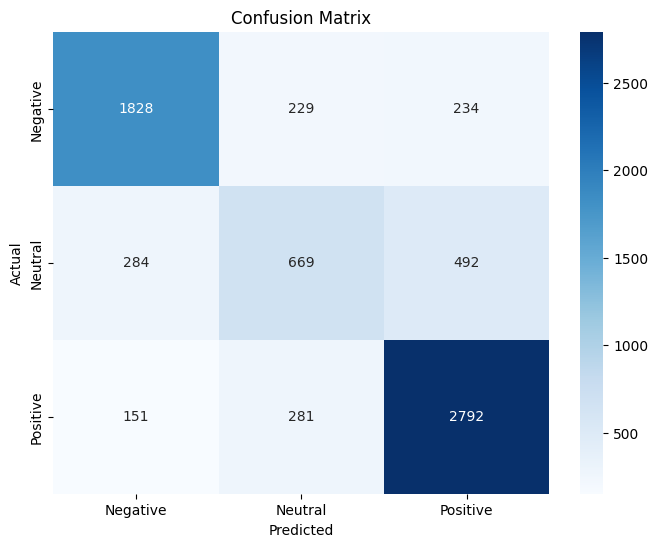

In [10]:
# Compute test metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f_score = f1_score(test_labels, test_predictions, average="weighted")
test_precision = precision_score(test_labels, test_predictions, average="weighted")
test_recall = recall_score(test_labels, test_predictions, average="weighted")

# Display the final test metrics
print(f"Test Accuracy: {test_accuracy:.4f}, F Score: {test_f_score:.4f}")
print(f"nTest Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix:")
print(cm)

# Visualizing the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()